In [66]:
import nltk
import re
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn import metrics

from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

nltk.download('stopwords')
en_stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/camelia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 80. Turning words into numeric IDs

In [67]:
_DATA_PATH = "../chapter06/text/"
_CATEGORY_TO_INDEX = {
    "b" : 0,
    "t" : 1,
    "e" : 2,
    "m" : 3
}

In [68]:
def _read_data(data_type: str) -> list:
    dataset = pd.read_csv(f"{_DATA_PATH}{data_type}.txt", sep="\t")
    df = pd.DataFrame(dataset)
    return list(df[df.columns[0]])

def _get_tokens(sentences: list) -> list:
    tokens_list = []
    for sentence in sentences:
        all_tokens = word_tokenize(sentence.lower())
        filtered_tokens = [word for word in all_tokens if not word in en_stop_words]
        final_tokens = []
        for token in filtered_tokens:
            token_out_punctuation = re.sub(r'\W+', "", token)
            if len(token_out_punctuation) > 1:
                final_tokens.append(token_out_punctuation)
        tokens_list.append(final_tokens)
    return tokens_list
    
def _count_tokens(tokens_per_sentences: list) -> map:
    frequence = Counter()
    for tokens_in_sentence in tokens_per_sentences:
        for token in tokens_in_sentence:
            frequence[token] += 1
    mult_occurences = []
    single_occurences = []
    for k in frequence:
        if frequence[k] > 1:
            mult_occurences.append((k, frequence[k]))
        else:
            single_occurences.append(k)
    mult_occurences.sort(key=lambda t: t[1], reverse=True)
    id_dict = {value[0]:i+1 for i, value in enumerate(mult_occurences)}
    for single_occurence in single_occurences:
        id_dict[single_occurence] = 0
    return id_dict

_sentences_train = _read_data("train")
_tokens_per_sentences = _get_tokens(_sentences_train)
_ID = _count_tokens(_tokens_per_sentences)

In [69]:
_ID

{'new': 1,
 'us': 2,
 'kardashian': 3,
 'kim': 4,
 'says': 5,
 'nt': 6,
 'first': 7,
 'cyrus': 8,
 'miley': 9,
 'west': 10,
 'star': 11,
 'chris': 12,
 'kanye': 13,
 'may': 14,
 'justin': 15,
 'video': 16,
 'bieber': 17,
 'billion': 18,
 'day': 19,
 'stocks': 20,
 'the': 21,
 'wedding': 22,
 'could': 23,
 'china': 24,
 'shows': 25,
 'google': 26,
 'time': 27,
 'deal': 28,
 'reveals': 29,
 'million': 30,
 'home': 31,
 'show': 32,
 'world': 33,
 'beyonce': 34,
 'report': 35,
 'set': 36,
 'game': 37,
 'one': 38,
 'sales': 39,
 '2014': 40,
 'york': 41,
 'movie': 42,
 'years': 43,
 'fed': 44,
 'apple': 45,
 'lohan': 46,
 'death': 47,
 'selena': 48,
 'gomez': 49,
 'lindsay': 50,
 'get': 51,
 'two': 52,
 'ceo': 53,
 'tv': 54,
 'love': 55,
 'thrones': 56,
 'twitter': 57,
 'people': 58,
 'amid': 59,
 'paul': 60,
 'high': 61,
 'awards': 62,
 'big': 63,
 'facebook': 64,
 'jay': 65,
 'baby': 66,
 'profit': 67,
 'said': 68,
 'shares': 69,
 'george': 70,
 'rise': 71,
 'fans': 72,
 'film': 73,
 'mich

# 81. Prediction with an RNN

In [70]:
_DW = 300 # dimensionality of the word embeddings
_DH = 50 # dimensionality of the hidden state
_L = 4 # number of categories
_V = len(_ID) # number of words in the vocabulary

_EPOCHS = 100
_LR = 1e-3

In [71]:
def _generate_output(data_type: str) -> list:
    dataset = pd.read_csv(f"{_DATA_PATH}{data_type}.txt", sep="\t")
    df = pd.DataFrame(dataset)
    y = list(df[df.columns[1]].map(_CATEGORY_TO_INDEX))
    return torch.from_numpy(np.array(y))

y_train = _generate_output("train")
y_valid = _generate_output("valid")
y_test = _generate_output("test")

In [72]:
def _generate_input(data_type: str, vocab_len: int = _V, dim_embed: int = _DW) -> list:
    sentences = _read_data(data_type)
    tokens_per_sentences = _get_tokens(sentences)
    embeds = nn.Embedding(vocab_len, dim_embed)

    x = []
    max_sentence_len = 0
    for tokens_in_sentence in tokens_per_sentences:
        x_t = []
        for token in tokens_in_sentence:
            if token in _ID:
                #x_t = nn.functional.one_hot(torch.tensor(_ID[token]), num_classes=vocab_len)
                x_t.append(_ID[token])
        x.append(x_t)
        max_sentence_len = max(len(x_t), max_sentence_len)

    for x_t in x:
        for index in range(len(x_t), max_sentence_len):
            x_t.append(0)
    
    x_embed = embeds(torch.tensor(x, dtype=torch.long))
    print(x_embed.shape)
    return x_embed

x_train = _generate_input("train")
x_valid = _generate_input("valid")
x_test = _generate_input("test")

torch.Size([7550, 156, 300])
torch.Size([944, 13, 300])
torch.Size([944, 13, 300])


In [73]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.input_dim = input_dim
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, nonlinearity='relu')
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        h0 = Variable(torch.zeros(self.layer_dim, x.size(1), self.hidden_dim))
        out, hn = self.rnn(x, h0)
        out = torch.softmax(self.fc(out[:, -1, :]), dim=-1)
        return out

model = RNNModel(_DW, _DH, 1, _L)

# 82. Training with Stochastic Gradient Descent

In [74]:
def _calculate_loss(out: object, y: object, loss_fn: object) -> int:
    loss = loss_fn(out, y)
    loss.backward()
    return loss.item()

def _calculate_accuracy(x: object, y: object, model: object) -> int:
    y_pred = model(x).detach().numpy()
    return metrics.accuracy_score(y, np.argmax(y_pred, axis=1))

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=_LR)

losses_train = []
losses_valid = []
accuracies_train = []
accuracies_valid = []

for i in range(_EPOCHS):
    optimizer.zero_grad()

    x_train, y_train = Variable(x_train), Variable(y_train)
    out = model(x_train)
    loss_train = _calculate_loss(out, y_train, loss_fn)
    losses_train.append(loss_train)

    x_valid, y_valid = Variable(x_valid), Variable(y_valid)
    out = model(x_valid)
    loss_valid = _calculate_loss(out, y_valid, loss_fn)
    losses_valid.append(loss_valid)
    
    accuracies_train.append(_calculate_accuracy(x_train, y_train, model))
    accuracies_valid.append(_calculate_accuracy(x_valid, y_valid, model))

    optimizer.step()

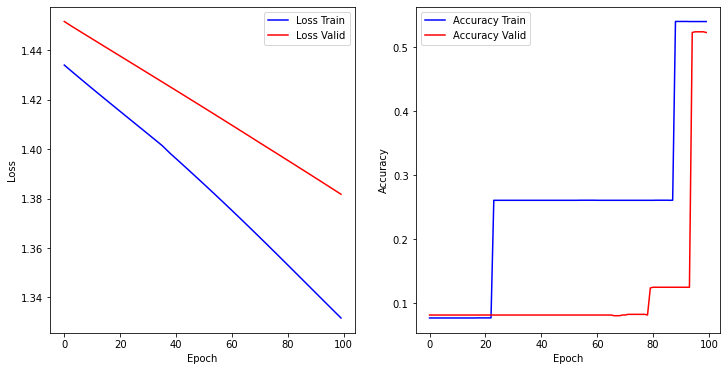

In [75]:
def _display_1_ax(ax: object, data_train: list, data_valid: list, label: str, LENGTH: int) -> None:
    ax.plot(LENGTH, data_train, color="blue", label=f"{label} Train")
    ax.plot(LENGTH, data_valid, color="red", label=f"{label} Valid")
    ax.set_xlabel("Epoch")
    ax.set_ylabel(label)
    ax.legend()

def _display_loss_acc(EPOCHS: int,
                      losses_train: list,
                      losses_valid: list,
                      accuracies_train: list,
                      accuracies_valid: list) -> None:
    LENGTH = range(EPOCHS)
    fig, ax = plt.subplots(figsize=(12, 6), nrows=1, ncols=2)
    _display_1_ax(ax[0], losses_train, losses_valid, "Loss", LENGTH)
    _display_1_ax(ax[1], accuracies_train, accuracies_valid, "Accuracy", LENGTH)
    plt.show()
    
_display_loss_acc(_EPOCHS, losses_train, losses_valid, accuracies_train, accuracies_valid)

# 83. Mini-batch Training, GPU Training

# 84. Add Pretrained Word Embeddings

# 85. Bi-directional RNN and Multi-layer RNN

# 86. Convolutional Neural Networks (CNN)

# 87. CNN Learning via Stochastic Gradient Descent

# 88. Hyper-parameter Tuning

# 89. Transfer Learning from a Pretrained Language Model